<a href="https://colab.research.google.com/github/LucioFassarella/ComQ/blob/main/ComQ_Quantizacao_de_funcao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantização de função

Dada uma função $f: \mathbb{B}^n\rightarrow \mathbb{R}$, definimos o seguinte *estado de $f$* e *operador de $f$* no registro quântico de $n$ qubits, respectivamente:
$$
\ket{f}:= \frac{1}{\norm{f}}\sum_{z = 0}^{2^n-1}f(z)\ket{z},\ \ \norm{f}:= \sqrt{\sum_{z = 0}^{2^n-1} \abs{f(z)}^2};
$$
$$
\begin{split}
H_f  &= \sum_{z = 0}^{2^n-1} f(z)\ketbra{z}{z}.
\end{split}
$$

Considere a decomposição das projeções nos estados da base computacional de 1 qubit:
$$
\ketbra{z}{z} = \frac{I + (-1)^z Z}{2},\ z \in \mathbb{B}.
$$
Então:
$$
\begin{split}
\ketbra{\mathbf{z}}{\mathbf{z}} &= \bigotimes_{k=0}^{2^n-1}\frac{I + (-1)^{z_k}Z_k}{2}.
\end{split}
$$
Escrevendo
$$
\mathbf{z} = (z_0, z_1, \dots, z_{n}) = \mathbf{z}'\times \left\{z_n\right\},\ \ \mathbf{z}' = (z_0, z_1, \dots, z_{n-1}),
$$
deduzimos a seguinte relação de recorrência para $\ketbra{\mathbf{z}}{\mathbf{z}}$:

$$
\begin{split}
\ketbra{\mathbf{z}}{\mathbf{z}} &= \ketbra{\mathbf{z}'}{\mathbf{z}'} \otimes \ketbra{z_n}{z_n}\\
&= \ketbra{\mathbf{z}'}{\mathbf{z}'} \otimes \left( \frac{I+(-1)^{z_{n}}Z_n}{2} \right)\\
&= \frac{1}{2}\ketbra{\mathbf{z}'}{\mathbf{z}'} \otimes I + %
\frac{(-1)^{z_{n}}}{2}\ketbra{\mathbf{z}'}{\mathbf{z}'}\otimes Z_n
\end{split}
$$
Essa relação de recorrência nos permite construir sistematicamente o operador de $f$ no registro quântico por um processo recursivo.


## Instalação de pacotes e métodos

In [ ]:
'''
Instalação do Qiskit e pacotes de visualização
'''
!pip install qiskit -U
!pip install qiskit_aer
!pip install qiskit-ibm-runtime

import qiskit
qiskit.__version__

!pip install matplotlib
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 134.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.8/366.8 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=b71b862f759b1fd17400790dc3e560082aa4b9081707060042df106d42b7dcab
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a17

In [ ]:
'''
Pacotes e Métodos
'''

# NumPy e SciPy
import numpy as np
import scipy as sp

# Minimizador do SciPy
from scipy.optimize import minimize

# Métodos do Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit.circuit.library import QAOAAnsatz

# Estimadores do Qiskit
from qiskit_aer.primitives import Estimator # <-- Estimator para simulação clássica
from qiskit_ibm_runtime import EstimatorV2 as Estimator # <-- Estimator para computação quântica
from qiskit_ibm_runtime import SamplerV2 as Sampler # <-- Estimator para computação quântica

# Qiskit Runtime
#from qiskit_ibm_runtime import QiskitRuntimeService, Session

import time

In [ ]:
'''
Métodos para execução da estratégia QAOA
'''

# Conecção com a IBM

token_privado = "..." # <-- Inserir token privado na IBM
instance_do_projeto = "..." # <-- Inserir instance do projeto

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token = token_privado,
    instance = instance_do_projeto
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Importação do Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Importação do Sampler
## Simulação local
from qiskit.primitives import StatevectorSampler # For local simulation
sampler = StatevectorSampler()
## Simulação na IBM:
#from qiskit_ibm_runtime import SamplerV2
# sampler = SamplerV2(mode = backend)

# Transpilador

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

## Funções primitivas e métodos específicos

In [ ]:
def qiskit_estimator(circuito_sem_medidas, hamiltoniano, precisao = None, backend = None):
    '''
    Método para executar o Estimator

    Input:
        circuito : circuito quântico que prepara um estado de qubits
        hamiltoniano (SparsePauliOp): hamiltoniano a ser medido
        precisao (float): precisão do resultado
        backend  : backend para rodar o Estimator

    Saída:
        resultado do Estimator
    '''

    # Importação de métodos e backend

    from qiskit_ibm_runtime import EstimatorV2 as Estimator
    from qiskit.transpiler import generate_preset_pass_manager

    # Use the existing service object
    # service = QiskitRuntimeService()
    if backend is None:
        from qiskit_ibm_runtime.fake_provider import FakeBrisbane
        backend = FakeBrisbane()
    else:
        backend = backend

    if precisao is None:
        precisao = 2**(-10)
    else:
        precisao = precisao

    # Transpilação

    pm = generate_preset_pass_manager(backend = backend, optimization_level=1)
    isa_circuito = pm.run(circuito_sem_medidas)
    isa_hamiltoniano = hamiltoniano.apply_layout(isa_circuito.layout)

    # Estimator:

    estimator = Estimator(mode=backend)

    # Job
    job = estimator.run([(isa_circuito, isa_hamiltoniano, )])
    pub_result = job.result()[0]

    return pub_result.data.evs

In [ ]:
def qiskit_sampler(circuito_com_medidas, shots = None, backend = None):
    '''
    Método para executar o Sampler

    Input:
        circuito : circuito quântico que prepara um estado de qubits
        backend  : backend para rodar o Sampler

    Saída:
        resultado do Sampler

    Observação: os resultados do Sampler são rotulados pelo nomes dos registros clássicos.
                Para um circuito com medidas definidas por 'measure_all', o rótulo é 'meas'.
                Para circuitos com medidas definidas de início sem denominação explícita,
                os rótulos são 'c', 'c1', 'c2', etc.
    '''

    # Importação de métodos e backend

    from qiskit_ibm_runtime import SamplerV2 as Sampler

    if backend is None:
        from qiskit_ibm_runtime.fake_provider import FakeBrisbane
        backend = FakeBrisbane()
    else:
        backend = backend

    from qiskit.transpiler import generate_preset_pass_manager
    pm = generate_preset_pass_manager(optimization_level=2, backend = backend)

    # Transpilação

    isa_circuitos = pm.run(circuito_com_medidas)

    if shots is None:
        shots = 2**10
    else:
        shots = shots

    sampler = Sampler(backend)
    job = sampler.run([(isa_circuitos, )], shots = shots)
    result = job.result()
    counts = result[0].data['meas'].get_counts()

    return counts, result

In [ ]:
def binario(z = 'int', num_bits = 'int'):
    '''
    Método que recebe um número inteiro e retorna a lista dos coeficientes de sua
     representação binária em ordem anti-lexicográfica (da direita para a esquerda).

    Entrada:
        z (int): número inteiro

    Saída:
        bits (list): lista dos coeficientes de sua representação binária

    '''

    string = bin(z)[2:].zfill(num_bits)
    lista = [int(bit) for bit in list(string)]
    lista.reverse()
    return lista

def operador_projecao(bits = list, num_qubits = 'int'):
    '''
    Método que recebe uma lista binária e retorna uma lista com formato do argumento
     do método "from_sparse_list" do método SparsePauliOp do Qiskit,
     com a diferença de que os elementos do resultado são lists e não tuples.
    Exemplo de saída (com apenas dois termos):
     [("I",[0],.25), ("Z", [0], .25), ("Z", [1], .25), ("ZZ", [0,1], .25)]

    Entrada:
        bits: lista binária
        num_qubits: número total de qubits

    Saída:
        lista com formato do argumento do método "from_sparse_list" do método SparsePauliOp do Qiskit.

    Métodos requeridos:
        from qiskit import QuantumCircuit
        from qiskit.quantum_info import SparsePauliOp

    '''

    # Validação da entrada

    if type(bits) != list:
        return print("O argumento 'z' deve ser uma lista binária (cujos termos são inteiros '0' ou '1').")

    for bit in bits:
        if bit != 0 and bit != 1:
            return print("O argumento 'z' deve ser uma lista binária (cujos termos são inteiros '0' ou '1').")

    # Parte principal

    n = len(bits)

    if n == 1:
        proj = SparsePauliOp(["I", "Z"], [0.5, ((-1)**(bits[0]))*0.5])

        # Completamento do tamanho
        if num_qubits > 1:
            proj = proj.expand(SparsePauliOp("I"*(num_qubits-1), [1]))
        return proj

    else:
        proj = SparsePauliOp(["I", "Z"], [0.5, ((-1)**bits[n-1])*0.5])
        pauli = projecao(bits[0:n-1], n-1).expand(proj)

        # Completamento do tamanho
        if num_qubits > n:
             pauli = pauli.expand(SparsePauliOp("I"*(num_qubits-n), [1]))

        pauli = pauli.simplify()
        return pauli

In [ ]:
def operador_funcao(funcao = 'function', num_qubits = 'int'):
    '''

    Método que constrói o operador de uma função complexa com variáveis inteiras

    Entradas:
        num_qubits  (int): número de qubits do circuito
        funcao (function): funcao real com variável inteira

    Saída:
        H (SparsePauliOp): operador

    Métodos requeridos:
        from qiskit import QuantumCircuit
        from qiskit.quantum_info import SparsePauliOp

    '''

    projecoes_lista = []

    for z in range(2**num_qubits):
        bits = binario(z, num_qubits)
        proj = operador_projecao(bits, num_qubits)
        coeficiente = SparsePauliOp("I"*num_qubits, funcao(z))
        proj_funcao = coeficiente.compose(proj)
        projecoes_lista.append(proj_funcao)

    H = sum(projecoes_lista).simplify()

    return H

In [ ]:
def circuito_funcao(funcao = 'function', num_qubits = 'int'):
    '''
    Método que contrói o circuito que implementa o estado quântico da função 'funcao'.
    A construção é realizada via método "initialize" do QuantumCircuit do Qiskit.

    Entradas:
        num_qubits  (int): número de qubits do circuito
        funcao (function): funcao real com variável inteira

    Saída:
        qc: circuito quântico (sem medidas)

    Métodos requeridos:
        from qiskit import QuantumCircuit
        from qiskit.quantum_info import Statevector

    '''

    '''
    ### Verificação da consistência dos dados de entrada
    '''

    if type(num_qubits) != int:
        return print("O segundo argumento 'num_qubits' deve ser um inteiro positivo.")

    '''
    ### Código principal
    '''
    norma = 0
    for k in range(2**num_qubits):
        norma += funcao(k)**2
    norma = np.sqrt(norma)

    if norma == 0:
        return print("A função é nula.")

    amplitudes = [f(k)/norma for k in range(2**num_qubits)]
    #np_coeficientes = np.array(amplitudes)

    estado_vetor = Statevector(amplitudes)

    qc = QuantumCircuit(num_qubits)

    qc.initialize(estado_vetor)

    return qc


In [ ]:
def circuito_estadoBase(z = 'int', num_qubits = 'int'):
    '''
    Método que recebe um número inteiro 'z' e o número de qubits 'num_qubits' para
     retornar o circuito quântico com 'num_qubits' qubits no registro quântico
     preparado no estado da base computacional correspondente ao número 'z'.

    Entradas:
        z (int): número inteiro
        num_qubits (int): número de qubits

    Saída:
        qc (QuantumCircuit): circuito quântico

    Métodos requeridos:
        binario (function): retorna a lista dos coeficientes de sua representação binária em ordem anti-lexicográfica (da direita para a esquerda)
        from qiskit import QuantumCircuit
    '''

    # Verificação da consistência dos dados de entrada
    if type(z) != int:
        return print("O primeiro argumento 'z' deve ser um inteiro positivo.")

    if type(num_qubits) != int:
        return print("O segundo argumento 'num_qubits' deve ser um inteiro positivo.")

    if z >= 2**num_qubits:
        return print("O primeiro argumento 'z' deve ser menor do que 2 na potência do segundo argumento 'num_qubits'.")

    bits = binario(z, num_qubits)
    qc = QuantumCircuit(num_qubits)
    for k in range(num_qubits):
        if bits[k] == 1:
            qc.x(k)
    return qc

# Testes

Número 5. Número de qubits = 4
Circuito estadoBase |5>:


┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

Circuito medindo o estado |5>:


┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        └───┘ ░ └╥┘┌─┐      
   q_1: ──────░──╫─┤M├──────
        ┌───┐ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        └───┘ ░  ║  ║ └╥┘┌─┐
   q_3: ──────░──╫──╫──╫─┤M├
              ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3

({'0101': 990, '0111': 8, '1101': 9, '0001': 10, '0100': 6, '0000': 1}, PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2}))
Contagens: {'0101': 990, '0111': 8, '1101': 9, '0001': 10, '0100': 6, '0000': 1}


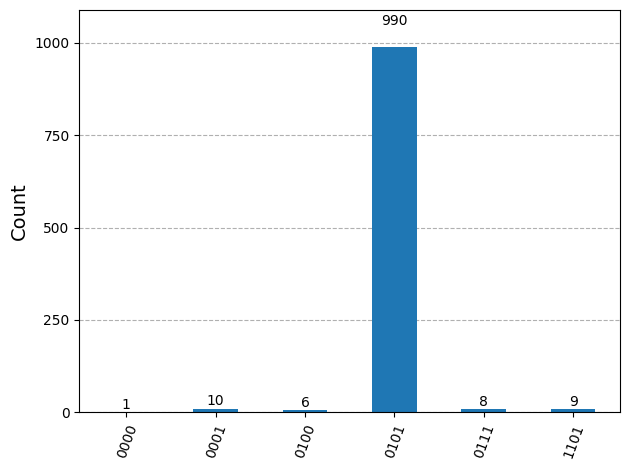

In [ ]:
'''
TESTE do método 'circuito_estadoBase'

Racional do teste:

O método 'circuito_estadoBase' recebe um número inteiro 'z' e retorna o circuito que
 prepara o correspondente estado da base computacional.
 Portanto, a medida na base computacional de um ensamble de circuitos preparados
 no estado '|z>' deve resultar no estado |z> com probabilidade 100%.
'''

z = 5
num_qubits = 4
print(f"Número {5}. Número de qubits = {num_qubits}")
qc = circuito_estadoBase(z, num_qubits)
print(f"Circuito estadoBase |{z}>:")
display(qc.draw())

# Experimento
qc.measure_all()
print(f"Circuito medindo o estado |{z}>:")
display(qc.draw())

counts = qiskit_sampler(qc, 2**10)
print(counts)
print(f"Contagens: {counts[0]}")

# Visualização
from qiskit.visualization import plot_histogram
plot_histogram(counts[0])

In [ ]:
'''
TESTE do método 'operador_projecao'

Racional do teste:

O método 'operador_projecao' constrói o circuito que recebe um número inteiro 'z' e
 constrói o operador projeção no correspondente estado da base computacional: '|z><z|'.
 Portanto, a medida na base computacional de um ensamble de circuitos preparados
 num estado qualquer deve retornar o estado |z> com a probabilidade correspondente.
 Em particular, preparando o circuito numa superposição homogênea de estados da
 base computacional deve retornar todos os estados da base computacional com a
 mesma probabilidade e a média da projeção igual a 1/num_qubits^2.
'''

num_qubits = 2
z = 3

print(f"EXPERIMENTO: Medida da projeção |{z}><{z}| no estado |{z}>")

bits = binario(z, num_qubits)
print(f"Bits do número {z}: {bits}")

# Preparação do estado |z>
qc = circuito_estadoBase(z,num_qubits)
print(f"Circuito que prepara o estado |{z}>:")
display(qc.draw())

# Projeção no estado |z> e medida

proj = circuito_projecao(bits, num_qubits)
print(f"Projeção |{z}><{z}|: {proj}")

valor_esperado = qiskit_estimator(qc, proj)
print(f"Valor esperado da projeção |{z}><{z}| no estado |{z}>: Expectativa: {1}. Medida: {valor_esperado}")


# Preparação de um estado |w> diferente de |z>
print(f"EXPERIMENTO: Medida da projeção |{z}><{z}| no estado |{w}>")
w = 1
bits2 = binario(w, num_qubits)
print(f"Bits do número {w}: {bits2}")

qc_w= circuito_estadoBase(w,num_qubits)
print(f"Circuito que prepara o estado |{w}>:")
display(qc_w.draw())

valor_esperado = qiskit_estimator(qc_w, proj)
print(f"Valor esperado da projeção |{z}><{z}| no estado |{w}>:  Expectativa: {0}. Medição: {valor_esperado}")


# Preparação da superposição uniforme H^num_qubits|0>
print(f"EXPERIMENTO: Medida da projeção |{z}><{z}| no estado de superposição uniforme H^num_qubits |{0}>")

bits2 = binario(w, num_qubits)

qc_s = QuantumCircuit(num_qubits)
for k in range(num_qubits):
    qc_s.h(k)
print(f"Circuito que prepara a superposição uniforme H^_num_qubits|0>:")
display(qc_s.draw())


valor_esperado = qiskit_estimator(qc_s, proj)
print(f"Valor esperado da projeção |{z}><{z}| na superposição uniforme H^_num_qubits|0>: Expectativa: {1/2**num_qubits}. Medição: {valor_esperado}")

EXPERIMENTO: Medida da projeção |3><3| no estado |3>
Bits do número 3: [1, 1]
Circuito que prepara o estado |3>:


┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘

Projeção |3><3|: SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])
Valor esperado da projeção |3><3| no estado |3>: Expectativa: 1. Medida: 0.9404296875
EXPERIMENTO: Medida da projeção |3><3| no estado |1>
Bits do número 1: [1, 0]
Circuito que prepara o estado |1>:


┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────

Valor esperado da projeção |3><3| no estado |1>:  Expectativa: 0. Medição: 0.030517578125
EXPERIMENTO: Medida da projeção |3><3| no estado de superposição uniforme H^num_qubits |0>
Circuito que prepara a superposição uniforme H^_num_qubits|0>:


┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

Valor esperado da projeção |3><3| na superposição uniforme H^_num_qubits|0>: Expectativa: 0.25. Medição: 0.251220703125


## Teste do método 'operador_funcao'

$$
f: \mathbb{N} \rightarrow \mathbb{Z},\ f(z) = z^2.
$$

EXPERIMENTO: Medida do operador função Hf no estado |3>


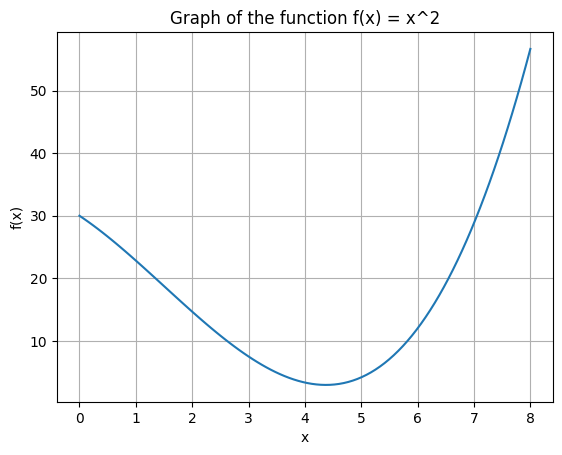

In [ ]:
'''
TESTE do método 'operador_funcao'

Racional do teste:

O método 'operador_funcao' constrói um operador auto-adjunto para uma função real de entrada.
 Esse operador auto-adjunto é diagonal na base computacional com os autovalores
 correspondendo aos valores da função original.
 Portanto, medindo o operador num ensamble de  circuitos preparados num dos
 estados da base computacional deve resultar no valor da função original no
 número do estado preparado:

 < k | Hf | k > = f(k)
'''


num_qubits = 3
z = 3

print(f"EXPERIMENTO: Medida do operador função Hf no estado |{z}>")

def f(z):
    return z**3/3 - 3*z**2/2 - 6*z + 30

# Plotagem
import matplotlib.pyplot as plt
import numpy as np

# Define the range for plotting
x = np.linspace(0, 2**num_qubits, 100)

# Calculate the function values
y = f(x)

# Plot the function
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Graph of the function f(x) = x^2")
plt.grid(True)
plt.show()

In [ ]:
Hf = operador_funcao(f, num_qubits)
print(f"Operador da função: {Hf}")

# Média no estado |z>

# Médoa na superposição uniforme H^num_qubits|0>

qc = QuantumCircuit(num_qubits)
for k in range(num_qubits):
    qc.h(k)

media = qiskit_estimator(qc, Hf, 2**(-12))
media_esperada = sum([f(k) for k in range(2**num_qubits)])/2**num_qubits
print(f"Média esperada: {media_esperada}. Média medida: {media}")

Operador da função: SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[-14.58333333+0.j,  -0.41666667+0.j,  -0.33333333+0.j,   2.        +0.j,
   3.33333333+0.j,   4.        +0.j,   8.        +0.j,  -2.        +0.j])
Média esperada: -14.583333333333334. Média medida: -14.239827473958336


Circuito que prepara o estado da função f:


<>:6: SyntaxWarning: invalid escape sequence '\k'
<>:6: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipython-input-3795587801.py:6: SyntaxWarning: invalid escape sequence '\k'
  \ket{f} = (1/\norma{f})sum_{z = 0}^{2**n-1}f(z)\ket{z}.


»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
meas: 3/»
        »
«        ┌────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                               ├»
«        │                                                                                │»
«   q_1: ┤1 Initialize(0.57772,0.43971,0.28244,0.14443,0.064191,0.080239,0.23109,0.55525) ├»
«        │                                                                                │»
«   q_2: ┤2                                                                               ├»
«        └────────────────────────────────────────────────────────────────────────────────┘»
«meas: 3/══════════════════════════════════════════════════════════════════════════════════»
«                                                                                          »
«         ░ ┌─┐      
«   q_0: ─░─┤M├──────
«         ░ └╥┘┌─┐   
«   q_1: ─░──╫─┤M├───
«         ░  ║ └╥┘┌─┐
«   q_2: ─░──╫──╫─┤M├
«         ░  ║  ║ └╥┘
«meas: 3/════╩══╩══╩═
«            0  1  2

Resultado do ensamble de medidas:
Contagens:
{'111': 1227, '000': 1307, '010': 320, '110': 258, '001': 735, '011': 131, '101': 70, '100': 48}


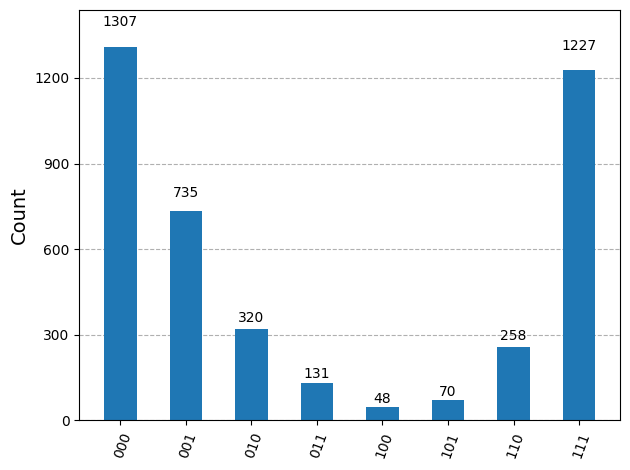

In [ ]:
'''
Teste do método 'circuito_funcao'

Racional do teste: O método constrói o circuito que prepara o estado quântico
 da função 'funcao'. Como as amplitudes de probabilidade são proporcionais aos
 valores da função, a medida de um ensamble de circuito preparados no estado da
 função deve resultar numa distribuição estatística com probabilidades
 proporcionais aos quadrados dos valores da função.
'''

qc = circuito_funcao(f, num_qubits)
qc.measure_all()
print(f"Circuito que prepara o estado da função f:")
display(qc.draw())

shots = 2**12 # Número de elementos do ensamble
counts, resultado = qiskit_sampler(qc, shots)
print(f"Resultado do ensamble de medidas:")
resultado
print(f"Contagens:")
print(counts)

# Visualização
from qiskit.visualization import plot_histogram
plot_histogram(counts)

Probabilidades:
{'111': 0.299560546875, '000': 0.319091796875, '010': 0.078125, '110': 0.06298828125, '001': 0.179443359375, '011': 0.031982421875, '101': 0.01708984375, '100': 0.01171875}
Gráfico dos valores da função proporcionais:


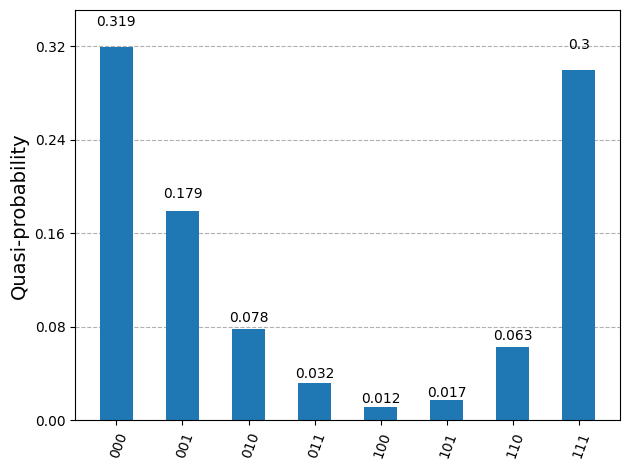

In [ ]:
probabilidades = {key: counts[key]/shots for key in counts.keys()}
print("Probabilidades:")
print(probabilidades)
print("Gráfico dos valores da função proporcionais:")
plot_histogram(probabilidades)

Coeficiente de normalização: 94.01683244070391
Valores da função normalizados:
{'111': np.float64(51.45740992383019), '000': np.float64(53.10842657451939), '010': np.float64(26.278503545827675), '110': np.float64(23.595842797307807), '001': np.float64(39.82624037722088), '011': np.float64(16.813622366594053), '101': np.float64(12.290644613201417), '100': np.float64(10.177620659624314)}
Gráfico dos valores da função normalizados:


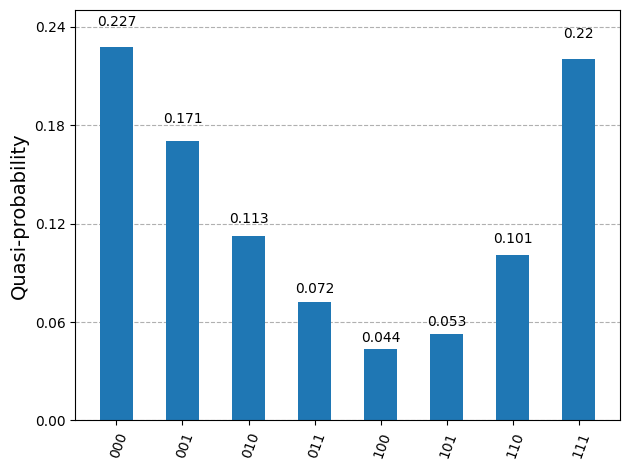

In [ ]:
# Normalização, a partir do conhecimento do valor da função em um ponto

coef = f(0)/probabilidades['000']
print(f"Coeficiente de normalização: {coef}")
funcao_valores = {key: coef*(np.sqrt(counts[key]/shots)) for key in counts.keys()}
print("Valores da função normalizados:")
print(funcao_valores)
print("Gráfico dos valores da função normalizados:")
plot_histogram(funcao_valores)

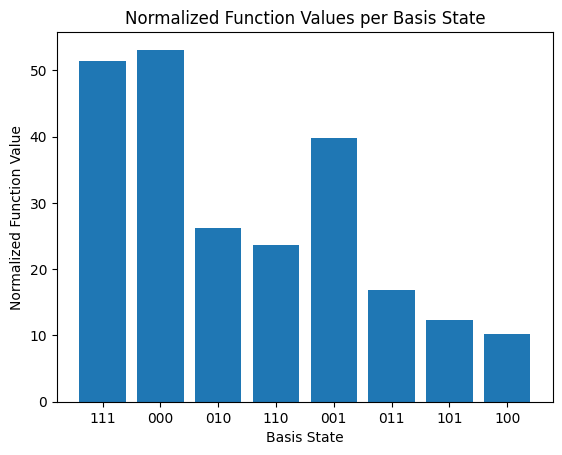

In [ ]:
# Use matplotlib to plot the bar graph of the dictionary
plt.bar(funcao_valores.keys(), funcao_valores.values())
plt.xlabel("Basis State")
plt.ylabel("Normalized Function Value")
plt.title("Normalized Function Values per Basis State")
plt.show()

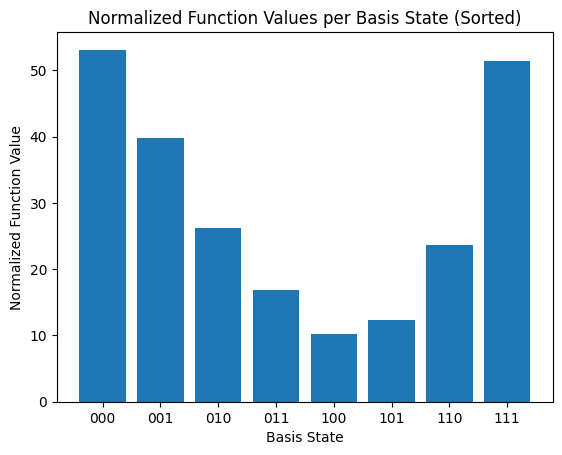

In [ ]:
# Sort the keys of the dictionary
sorted_keys = sorted(funcao_valores.keys())

# Get the values in the sorted order
sorted_values = [funcao_valores[key] for key in sorted_keys]

# Use matplotlib to plot the bar graph with sorted keys
plt.bar(sorted_keys, sorted_values)
plt.xlabel("Basis State")
plt.ylabel("Normalized Function Value")
plt.title("Normalized Function Values per Basis State (Sorted)")
plt.show()